Maximise $P(\bm{X}|\log L)$

In [110]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

In [316]:
def logPr_X_logL(logL, X, mean, covinv):
    thetastar = np.log(X)/(2*np.log(-logL))
    fprimes = abs(2/(thetastar**2) * np.log(X) * X**(2/thetastar))
    regularization = np.sum(np.log(fprimes))
    gaussian = 1/2 * (X - mean).T @ covinv @ (X - mean)
    return - regularization - gaussian

def logPr_gauss(X, mean, covinv):
    return -1/2 * (X - mean).T @ covinv @ (X - mean)

def minimise_X(logL, mean, covinv):
    def func(X):
        return - logPr_X_logL(logL, X, mean, covinv)
    solution = minimize(func, mean)#, method='Nelder-Mead')#, bounds=((0,1), (0,1), (0,1)))
    return solution

In [340]:
nk = 500 * np.ones(10)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [346]:
X_true = generate_Xs(nk)
theta_true = 10
y = simple.func(X_true, 10)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
X_max = minimise_X(y, mean_X, covinv_X).x
X_b = simple.inverse(y, theta_b)
# print(f'true: {X_true}')
# print(f'theta: {X_b}')
# print(f'X: {X_max}')

In [349]:
logPr_X_logL(y, X_true, mean_X, covinv_X)

52.4405064172086

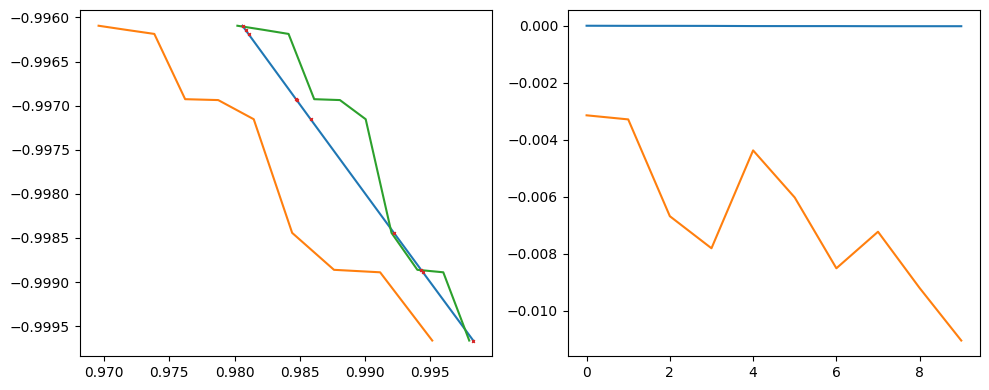

In [350]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(X_b, y)
ax1.plot(X_max, y)
ax1.plot(mean_X, y)
ax1.plot(X_true, y, 'x', ms=2)
ax2.plot(X_b - X_true)
ax2.plot(X_max - X_true)
plt.tight_layout()